In [1]:
import os
import glob
os.environ["ISISROOT"] = "/usgs/pkgs/isis3.7.0/install"
os.environ["ISIS3DATA"] = "/usgs/cpkgs/isis3/data"
from pysis import isis

from plio.io import io_controlnetwork
from knoten.csm import create_csm
from scipy import sparse
import ale
import random
import csmapi
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from knoten.bundle import *

/home/jmapel/.conda/envs/knoten/lib/python3.7/site-packages/ale/__init__.py:22: UserWarning: ALESPICEROOT environment variable not set, Spice Drivers will not function correctly
  warnings.warn('ALESPICEROOT environment variable not set, Spice Drivers will not function correctly')


## Load in Base Network

In [2]:
cubes = '/work/projects/control_network_metrics/registration_quality/cubes.lis'
sensors = generate_sensors(cubes, directory='data/', clean=True)

In [3]:
base_net_file = '/work/projects/control_network_metrics/registration_quality/hand.net'
base_net = io_controlnetwork.from_isis(base_net_file)

network_dir = '/work/projects/control_network_metrics/registration_quality/'

## Determine Solve Parameters

In [4]:
all_parameters = {sn: get_sensor_parameters(sensor) for sn, sensor in sensors.items()} #all parameters
parameters = {sn: parameter[6:12] for sn, parameter in all_parameters.items()} #just solving for camera angles and angle velocity

## Functions

In [5]:
def compute_sigma(V, W_parameters, W_observations):
    """
    Computes the resulting standard deviation of the residuals for the current state of the bundle network.
    
    Parameters
    ----------
    V  :  np.array
          The control network dataframe with updated ground points
    W_parameters  :  ndarray 
                     The parameter weight matrix (i.e.: sensor parameters and point weights)
    W_observations  :  ndarray
                     The observation weight matrix (i.e.: point weights)
    
    Returns
    -------
       : float64
         Standard deviation of the residuals
    
    """
    num_parameters = W_parameters.shape[0]
    num_observations = W_observations.shape[0]
    dof = num_observations - num_parameters
    VTPV = (V.dot(W_observations).dot(V))
    sigma0 = np.sqrt(VTPV/dof)
    return sigma0

def bundle_iteration(J, V, W_parameters, W_observations):
    """
    Parameters
    ----------
    J  :  ndarray
          The control network as a dataframe generated by plio.
    V  :  np.array
          The control network dataframe with updated ground points
    W_parameters  :  ndarray 
                     The parameter weight matrix (i.e.: sensor parameters and point weights)
    W_observations  :  ndarray
                     The observation weight matrix (i.e.: measure weights)
    
    Returns
    -------
    N  :  
    """
    
    N = J.T.dot(W_observations).dot(J) + W_parameters
    C = J.T.dot(W_observations).dot(V)
    dX = np.linalg.inv(N).dot(C)
    return N, dX

# For data snooping we need to calculate updated residuals
def compute_normalized_residual(J, V, N, W_parameters, W_observations):
    """
    Computes the normalized residual statistic for the data snooping method. Method derived from 
    Forstner 1985 "The Reliability of Block Triangulation"
    
    Parameters
    ----------
    V  :  np.array
          The control network dataframe with updated ground points
    N  :  
        
    W_parameters  :  ndarray 
                     The parameter weight matrix (i.e.: sensor parameters and point weights)
    W_observations  :  ndarray
                     The observation weight matrix (i.e.: point weights)
    
    Returns
    -------
       : np.array
         Normalized residual statistic for the data snooping
    
    """
    sigma0 = compute_sigma(V, W_parameters, W_observations)
    Qxx = np.linalg.inv(N)
    Qvv = np.linalg.inv(W_observations) - J.dot(Qxx).dot(J.T)
    qvv = np.diagonal(Qvv)
    sigma_vi = sigma0*np.sqrt(qvv)
    wi = -V/sigma_vi
    
    return wi

In [6]:
def check_network(network):
    """
    Check that all control points in a network have at least 2 remaining measures.
    
    Parameters
    ----------
    network : DataFrame
              The control network as a dataframe generated by plio
    
    Returns
    -------
     : list
       List of measure indices that were masked out for being the only measure on a point.
    """
    bad_measures = []
    for point_id, group in network.groupby('id'):
        if len(group) < 2:
            for measure_index, _ in group.iterrows():
                bad_measures.append(measure_index)
    return bad_measures

In [7]:
def compose_measure_name(measures):
    names = []
    for measure in measures:
        names.append(measure[0] + '|' + measure[1])
    return names

In [8]:
def add_error(network, num_measures, error_mag, noise_mean=None, noise_std=None):
    """
    Add error to a control network
    """
    error_net = network.copy()
    error_indices = random.sample(list(error_net.index), num_measures)
    for index in error_indices:
        error_angle = np.random.uniform(0, 2*np.pi, 1)[0]
        error_line = np.sin(error_angle) * error_mag
        error_sample = np.cos(error_angle) * error_mag
        error_net.loc[index, 'line'] += error_line
        error_net.loc[index, 'sample'] += error_sample
    
    if (noise_mean is not None) and (noise_std is not None):
        for index in [i for i in error_net.index if i not in error_indices]:
            noise_mag = np.random.normal(noise_mean, noise_std, 1)[0]
            noise_angle = np.random.uniform(0, 2*np.pi, 1)[0]
            noise_line = np.sin(noise_angle) * noise_mag
            noise_sample = np.cos(noise_angle) * noise_mag
            error_net.loc[index, 'line'] += noise_line
            error_net.loc[index, 'sample'] += noise_sample

    return error_net, error_indices

## Data Snooping Function

In [10]:
def data_snooping(network, sensors, parameters, k=3.29, verbose=True):
    """
    Parameters
    ----------
    network  :  DataFrame
                The control network as a dataframe generated by plio
    sensors  :  dict
                A dictionary that maps ISIS serial numbers to CSM sensors
    parameters  : list
                 The list of  CsmParameter to compute the partials W.R.T.
    k  :  float64
          Critical value used for rejection criteria; defaults to Forstner's 3.29 
          (or Baarda's 4.1??)
    verbose : bool
              If status prints should happen
    
    Returns
    -------
      :  list
      Indices of the network DataFrame that were rejected during data snooping
    """
    net = network 
    net['mask'] = False

    rejected_indices = []
    awi = np.array([5, 5, 5, 5]) #initialize larger than k so you get into first iteration
    while (awi > k).any():

        # weight matrices
        coefficient_columns = compute_coefficient_columns(net[~net['mask']], sensors, parameters)
        num_parameters = max(col_range[1] for col_range in coefficient_columns.values())
        W_parameters = compute_parameter_weights(net[~net['mask']], sensors, parameters, coefficient_columns)
        num_observations = 2 * len(net[~net['mask']])
        W_observations = np.eye(num_observations)

        # bundle iteration (and set up)
        V = compute_residuals(net[~net['mask']], sensors)
        J = compute_jacobian(net[~net['mask']], sensors, parameters, coefficient_columns)
        sigma0 = compute_sigma(V, W_parameters, W_observations)
        N, dX = bundle_iteration(J, V, W_parameters, W_observations)

        # calculate test statistic
        wi = compute_normalized_residual(J, V, N, W_parameters, W_observations)
        awi = abs(wi)

        #find maximum
        imax = np.argmax(awi)
        if verbose:
            print(f'max wi = {awi[imax]}') # display

        if awi[imax] <= k:
            if verbose:
                print('Data Snooping Outlier Rejection Complete')
            break

        reject_index = floor(imax/2)
        reject = net.index[~net['mask']][reject_index]
        net.loc[reject, ['mask']] = True
        rejected_indices.append(reject)
        if verbose:
            print(f'max wi index = {imax}')
            print(f'max wi measure index = {reject_index}')
            print(f'rejecting measure {net.loc[reject, ["id", "serialnumber"]].values}')
        
        not_enough_measures = check_network(net[~net['mask']])
        if (not_enough_measures):
            for measure_index in not_enough_measures:
                if verbose:
                    print(f'single measure point {net.loc[measure_index, "id"]}')
                    print(f'rejecting measure {net.loc[measure_index, ["id", "serialnumber"]].values}')
                net.loc[measure_index, ['mask']] = True
        
        if verbose:
            print('')
            
    return rejected_indices


## Run a test 500 times

In [15]:
num_tests = 500
error_mag = 25
num_measures = 4

false_negative = np.zeros(num_tests)
found = np.zeros(num_tests)
false_positive = np.zeros(num_tests)
for i in range(num_tests):
    print(f'Running test {i+1}')
    error_net, error_indices = add_error(base_net, num_measures, error_mag)
    compute_apriori_ground_points(error_net, sensors)
    rejected_indices = data_snooping(error_net, sensors, parameters, verbose=False)
    error_set = set(error_indices)
    rejected_set = set(rejected_indices)
    false_negative[i] = len(error_set.difference(rejected_set))
    found[i] = len(error_set.intersection(rejected_set))
    false_positive[i] = len(rejected_set.difference(error_set))

Running test 1
Running test 2
Running test 3
Running test 4
Running test 5
Running test 6
Running test 7
Running test 8
Running test 9
Running test 10
Running test 11
Running test 12
Running test 13
Running test 14
Running test 15
Running test 16
Running test 17
Running test 18
Running test 19
Running test 20
Running test 21
Running test 22
Running test 23
Running test 24
Running test 25
Running test 26
Running test 27
Running test 28
Running test 29
Running test 30
Running test 31
Running test 32
Running test 33
Running test 34
Running test 35
Running test 36
Running test 37
Running test 38
Running test 39
Running test 40
Running test 41
Running test 42
Running test 43
Running test 44
Running test 45
Running test 46
Running test 47
Running test 48
Running test 49
Running test 50
Running test 51
Running test 52
Running test 53
Running test 54
Running test 55
Running test 56
Running test 57
Running test 58
Running test 59
Running test 60
Running test 61
Running test 62
Running test 63
R

Running test 490
Running test 491
Running test 492
Running test 493
Running test 494
Running test 495
Running test 496
Running test 497
Running test 498
Running test 499
Running test 500


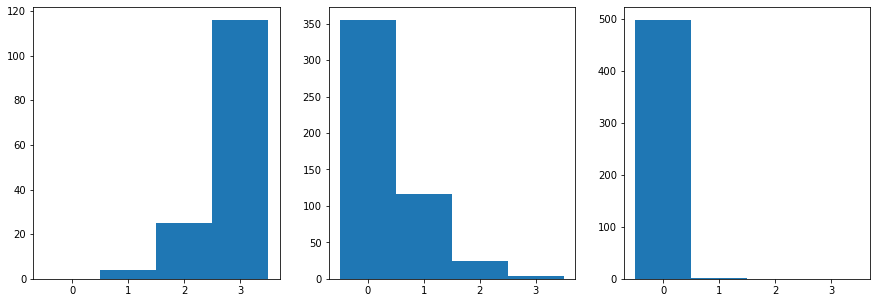

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.hist(false_negative, np.arange(0, num_measures+1) - 0.5)
ax2.hist(found, np.arange(0, num_measures+1) - 0.5)
ax3.hist(false_positive, np.arange(0, num_measures+1) - 0.5)
plt.show()